In [1]:
from pyspark.sql import SQLContext, Row, DataFrame, HiveContext, SparkSession
from pyspark.sql.functions import udf, col, lit, when, min as sql_min, collect_list, collect_set, count, desc
from pyspark.sql.types import *

sqlContext = SQLContext(sc)
sqlContext_H = HiveContext(sc)

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 250)

from datetime import datetime, date
import dateutil
import pandas as pd
import numpy as np
from collections import OrderedDict
from random import randint
from pyspark.sql.window import Window
import pyspark.sql.functions as func

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline


HOST = 'hdfs://ip-10-0-0-159.ec2.internal:8020'

# Read logs data

In [2]:
%%time

data = sqlContext.read.parquet(
    HOST + "/parquet/07/*",
    HOST + "/parquet/08/*",
    HOST + "/parquet/09/*"
)

def convert_dttm(x):
    try: return datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
    except: return None
def get_date(x):
    try: return x.date()
    except: return None
    
convert_dttm_udf = udf(convert_dttm, TimestampType())
convert_dt_udf = udf(get_date, DateType())

data = data.withColumn(
        "ACCESS_DTTM", convert_dttm_udf(col("ACCESS_DTTM"))
    ).withColumn(
        "ACCESS_DATE", convert_dt_udf(col("ACCESS_DTTM"))
    ).select(
        "ACCESS_DTTM", "ACCESS_DATE", 
        "PROCESS_ID", 
        "USER_ID",
        "WORKSTATION",
        "EPIC_PATIENT_ID", 
        "ENCOUNTER_DEPARTMENT", "ENCOUNTER_SERVICE_AREA",
        "MODULE", "METRIC_NAME", "METRIC_DESCRIPTION"
    ).persist()

sqlContext.registerDataFrameAsTable(data, "data")

CPU times: user 8.52 ms, sys: 4.21 ms, total: 12.7 ms
Wall time: 7.64 s


In [3]:
data.limit(5).toPandas()

,ACCESS_DTTM,ACCESS_DATE,PROCESS_ID,USER_ID,WORKSTATION,EPIC_PATIENT_ID,ENCOUNTER_DEPARTMENT,ENCOUNTER_SERVICE_AREA,MODULE,METRIC_NAME,METRIC_DESCRIPTION
0,2016-08-05 11:47:47,2016-08-05,prd-34538158,17404,HY6100,4250968,CLAY ANTICOAG CLINIC,"DMG-GLEN ELLYN CLINIC, S.C.",PATIENT DEMOGRAPHICS,REG_EPTADDRESS,Patient Address subcomponent accessed on Patient Demographics form.
1,2016-08-05 14:41:00,2016-08-05,prd-54133248,14456,HY6227,5418523,,,DEMOGRAPHIC,LAB_RESULT_DISPLAYED,Results are displayed
2,2016-08-05 14:41:00,2016-08-05,prd-52756522,1459,HY5143,4337661,,,PATIENT CLINICAL INFO,CE_DOCUMENTS,Care Everywhere Documents activity accessed.
3,2016-08-05 14:41:00,2016-08-05,prd-17499692,12039,WS1998,Z3241635,,,PATIENT CLINICAL INFO,MR_REPORTS,A report with patient data accessed.
4,2016-08-05 14:41:00,2016-08-05,prd-1115886,12039,,Z3241635,,,PATIENT ORDERS,MR_ORDER_TRANSMITTAL,Event for order transmittal action


# Count total records amount for three months

In [4]:
%%time
rows = sqlContext.sql("SELECT COUNT(ACCESS_DTTM) FROM data").collect()
rows = map(lambda x: x[0], rows)[0]
print "Records amount: ", rows

Records amount:  592518304
CPU times: user 239 ms, sys: 55.2 ms, total: 294 ms
Wall time: 47min 2s


# Count percentage of empty records and unique values

In [72]:
%%time

def stats(col):
    empty = sqlContext.sql("SELECT COUNT(*) FROM data WHERE {0} IS NULL OR {0} == ''".format(col)).collect()
    empty = map(lambda x: x[0], empty)[0]
    print "Empty {}: {}%".format(col, empty * 100.0 / rows)
    print "NOT empty {}: {}%".format(col, 100.0 - empty * 100.0 / rows )
    unique = sqlContext.sql("SELECT COUNT(DISTINCT({})) FROM data".format(col)).collect()
    unique = map(lambda x: x[0], unique)[0]
    print "Unique {2}s = {0}, percentage = {1:.3f}%".format(unique, unique * 100.0 / rows, col)
    
stats("PROCESS_ID")

Empty PROCESS_ID: 0.0%
NOT empty PROCESS_ID: 100.0%
Unique PROCESS_IDs = 778287, percentage = 0.131%
CPU times: user 55.5 ms, sys: 744 µs, total: 56.2 ms
Wall time: 11.4 s


---
> * All records have PROCESS_ID identifier
> * There about 800K unique PROCESS_ID

---

In [120]:
%%time

stats("USER_ID")
print("\n" + "-"*100)
stats("EPIC_PATIENT_ID")
print("\n" + "-"*100)
stats("WORKSTATION")
print("\n" + "-"*100)
stats("MODULE")
print("\n" + "-"*100)
stats("METRIC_NAME")
print("\n" + "-"*100)
stats("ENCOUNTER_DEPARTMENT")
print("\n" + "-"*100)
stats("ENCOUNTER_SERVICE_AREA")
print

Empty USER_ID: 0.0%
NOT empty USER_ID: 100.0%
Unique USER_IDs = 12866, percentage = 0.002%

----------------------------------------------------------------------------------------------------
Empty EPIC_PATIENT_ID: 10.8678657799%
NOT empty EPIC_PATIENT_ID: 89.1321342201%
Unique EPIC_PATIENT_IDs = 904343, percentage = 0.153%

----------------------------------------------------------------------------------------------------
Empty WORKSTATION: 3.3206071217%
NOT empty WORKSTATION: 96.6793928783%
Unique WORKSTATIONs = 12425, percentage = 0.002%

----------------------------------------------------------------------------------------------------
Empty MODULE: 4.19995666497%
NOT empty MODULE: 95.800043335%
Unique MODULEs = 39, percentage = 0.000%

----------------------------------------------------------------------------------------------------
Empty METRIC_NAME: 0.0%
NOT empty METRIC_NAME: 100.0%
Unique METRIC_NAMEs = 689, percentage = 0.000%

-------------------------------------------

---
> * All records have a defined user, i.e. we always know who is making requests
> * There are about 11% records where a patient is undefined
> * There are also about 3.3% of records where workstation is undefined. Almost all users may work on undefined workstation. Such behaviour still remains unclear
> * We may alsways know which action do a user, because METRIC_NAME (that describes event) is defined
> * ENCOUNTER_DEPARTMENT and ENCOUNTER_SERVICE_AREA mostly are undefined that's why cannot be used as some feature in general

---

# Calculate how many user / patients are related with a PROCESS_ID

In [50]:
%%time
query = " ".join([
    "SELECT PROCESS_ID, COUNT(DISTINCT(USER_ID)) AS USERS, COUNT(DISTINCT(EPIC_PATIENT_ID)) AS PATIENTS, COUNT(USER_ID) AS USAGE",
    "FROM data",
    "GROUP BY PROCESS_ID"
])

c = sqlContext.sql(query).persist()
c.show(10)

+------------+-----+--------+-----+
|  PROCESS_ID|USERS|PATIENTS|USAGE|
+------------+-----+--------+-----+
|prd-54198478|    2|       6|  288|
|prd-43909806|    5|     166| 2944|
|prd-17367470|    4|     108| 2860|
|prd-13501302|    7|      33|  719|
|prd-38535422|    3|      11|  985|
| prd-9307060|    5|     111| 3842|
|prd-10486784|    3|       5|  134|
|prd-24052168|    3|      21|  285|
|prd-11862230|    2|     200| 8891|
| prd-8913254|    5|     373|10220|
+------------+-----+--------+-----+
only showing top 10 rows

CPU times: user 283 ms, sys: 8.22 ms, total: 291 ms
Wall time: 47min 12s


### Let's plot a histogram

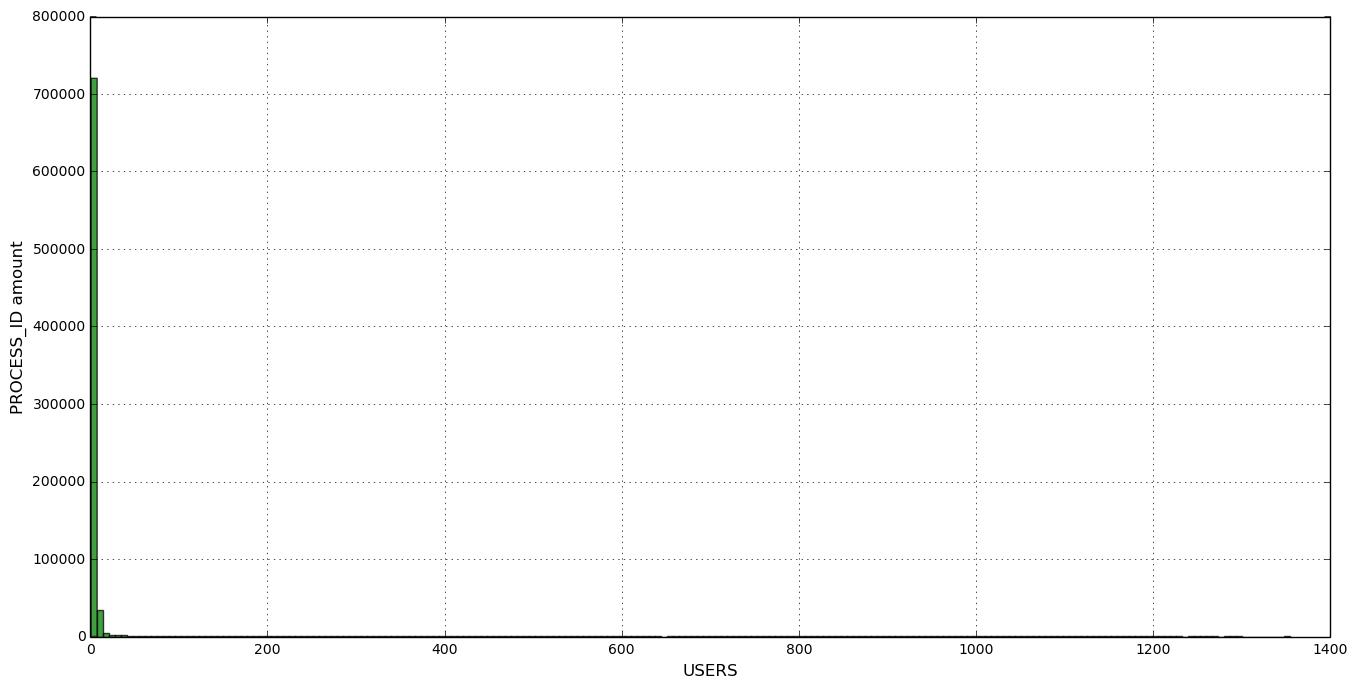

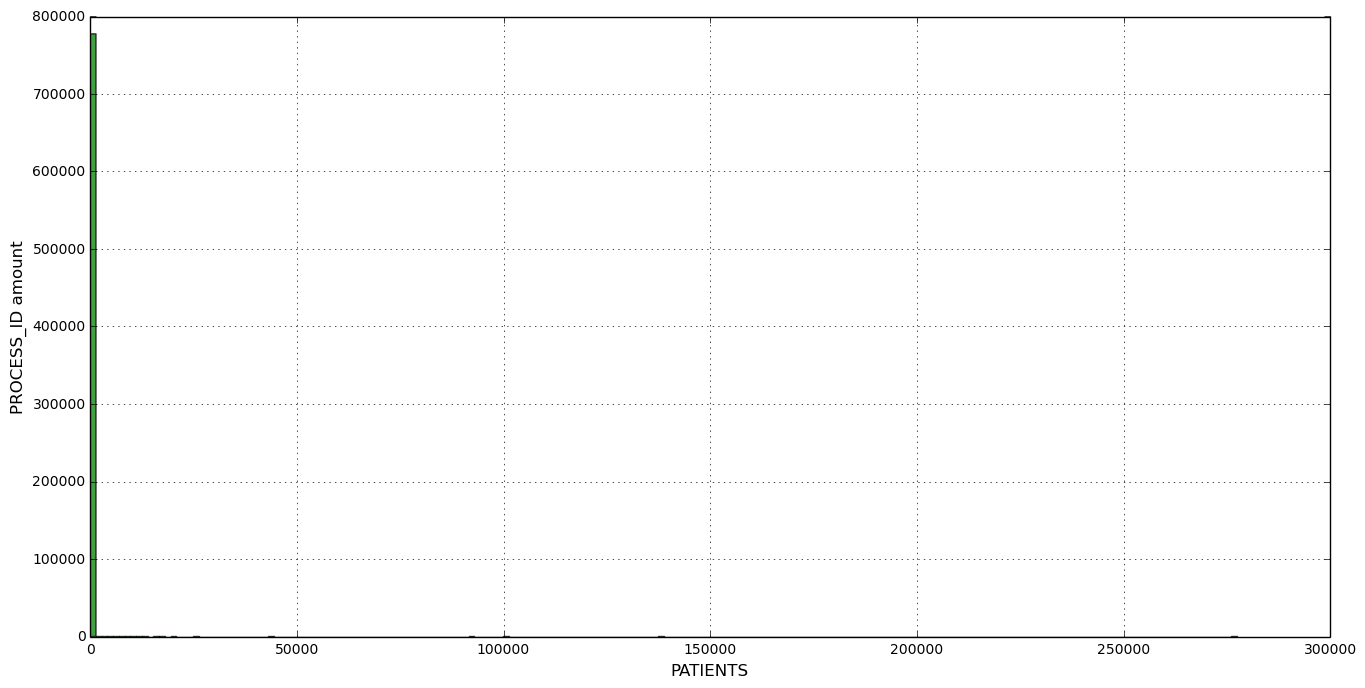

CPU times: user 17.3 s, sys: 345 ms, total: 17.6 s
Wall time: 18.9 s


In [51]:
%%time
def hist_draw(df, col, bins=200):
    plt.figure(figsize=(16, 8))
    x = np.array(map(lambda x: x[0], df.select(col).collect()))
    plt.hist(x, bins, facecolor='green', alpha=0.75)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('PROCESS_ID amount', fontsize=12)
    plt.grid(True)
    plt.show()
    
hist_draw(c, 'USERS')
hist_draw(c, 'PATIENTS')

---
> * The vast majority of users and patients work within a low amount of PROCESS_IDs. In other words, a lot of PROCESS_IDs have only few users / patients (see below histogram)
> * But we can observe also PROCESS_IDs with hundreds / thousands users and thousands / tens of thousands patients

---

Let's look more deeply

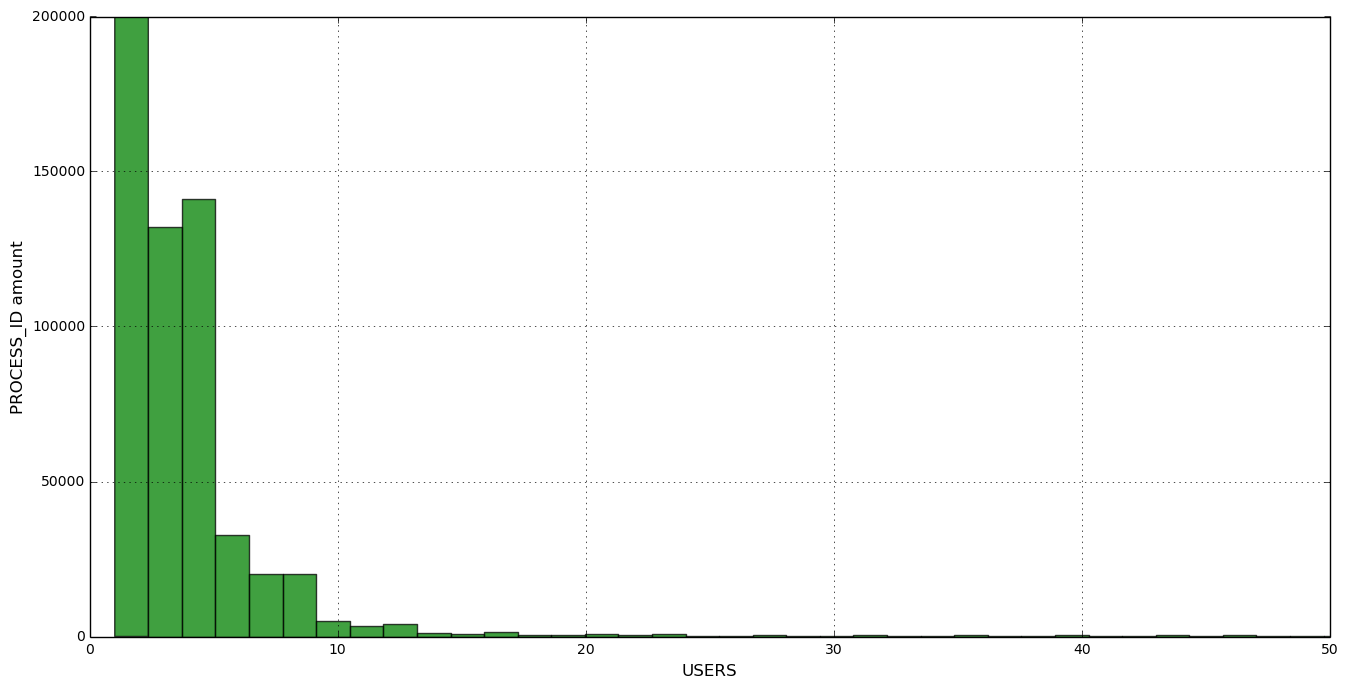

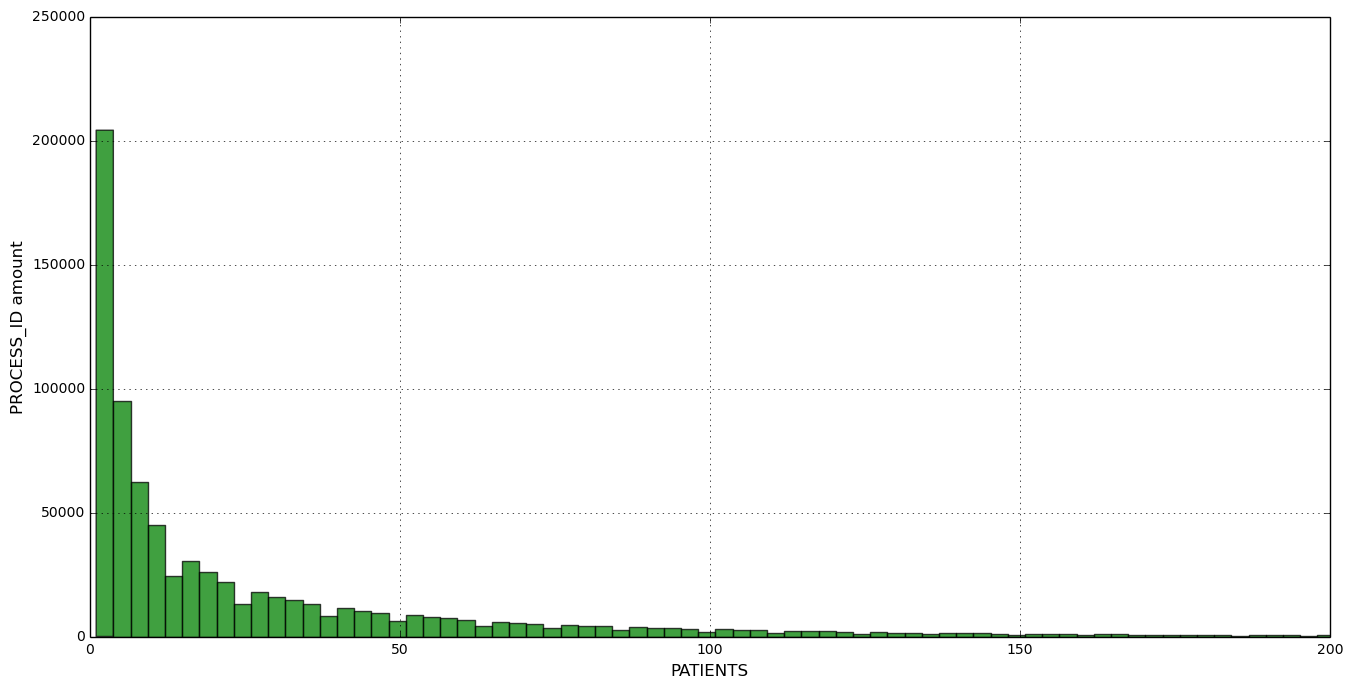

CPU times: user 3min 8s, sys: 1.61 s, total: 3min 9s
Wall time: 3min 10s


In [45]:
%%time
def hist_draw(df, col, bins=200, axis=[0, 100, 0, 100]):
    plt.figure(figsize=(16, 8))
    x = np.array(map(lambda x: x[0], df.select(col).collect()))
    plt.hist(x, bins, facecolor='green', alpha=0.75)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('PROCESS_ID amount', fontsize=12)
    plt.axis(axis)
    plt.grid(True)
    plt.show()
    
hist_draw(c, 'USERS', bins=1000, axis=[0, 50, 0, 200000])
hist_draw(c, 'PATIENTS', bins=100000, axis=[0, 200, 0, 250000])

# Let's display how many PROCESS_IDs has a user / patient

In [52]:
%%time
query = " ".join([
    "SELECT USER_ID, COUNT(DISTINCT(PROCESS_ID)) AS PROCESS_IDs, COUNT(ACCESS_DTTM) AS USAGE",
    "FROM data",
    "GROUP BY USER_ID"
])

u = sqlContext.sql(query).persist()
u.show(10)

+-------+-----------+------+
|USER_ID|PROCESS_IDs| USAGE|
+-------+-----------+------+
| 104870|        175|  1243|
|   8304|       2122|197104|
|  16250|       1483| 59142|
| 106768|        342| 31605|
| 100263|        408| 97944|
| 106506|       1281| 89877|
| 205151|        593| 28270|
| 102745|        175| 17310|
| 206477|        119| 10720|
|  17401|        662| 81078|
+-------+-----------+------+
only showing top 10 rows

CPU times: user 26.6 ms, sys: 4.43 ms, total: 31 ms
Wall time: 20 s


In [53]:
%%time
query = " ".join([
    "SELECT EPIC_PATIENT_ID, COUNT(DISTINCT(PROCESS_ID)) AS PROCESS_IDs, COUNT(ACCESS_DTTM) AS USAGE",
    "FROM data",
    "GROUP BY EPIC_PATIENT_ID"
])

p = sqlContext.sql(query).persist()
p.show(10)

+---------------+-----------+-----+
|EPIC_PATIENT_ID|PROCESS_IDs|USAGE|
+---------------+-----------+-----+
|        3929711|         60| 1047|
|        4385038|         75| 1381|
|        4433807|          1|    2|
|        5389403|          1|   16|
|        5397181|          1|    4|
|        6241830|          1|    1|
|        6255572|          1|    1|
|        4039849|        174| 3963|
|       Z2816715|          1|   11|
|        5648988|        100| 1720|
+---------------+-----------+-----+
only showing top 10 rows

CPU times: user 33.3 ms, sys: 394 µs, total: 33.7 ms
Wall time: 27 s


### Visualize results on histograms

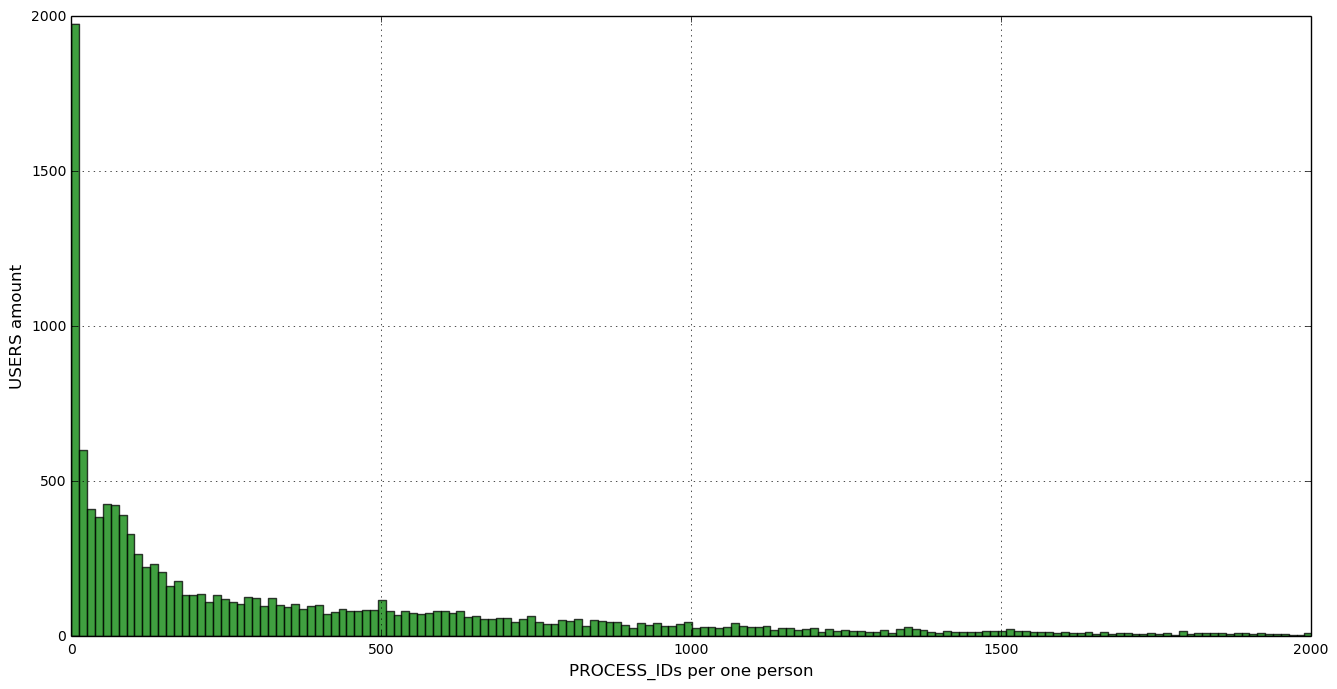

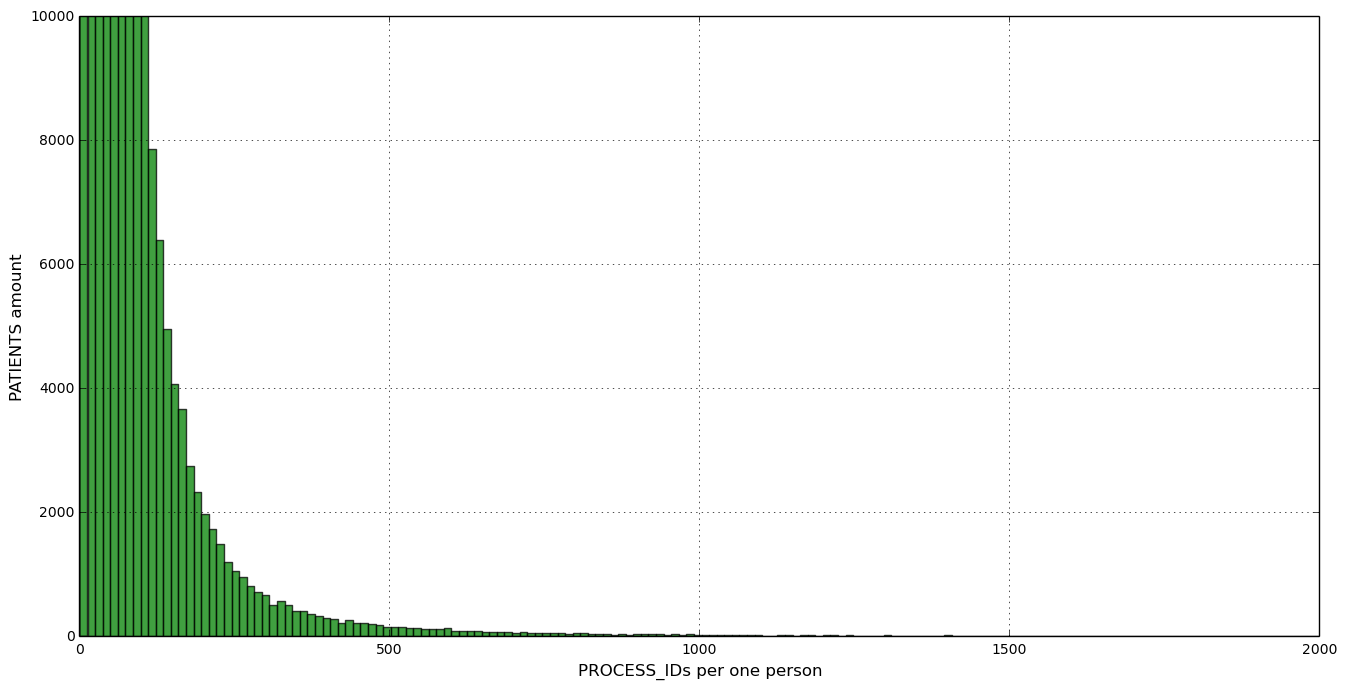

CPU times: user 1min 44s, sys: 979 ms, total: 1min 45s
Wall time: 1min 45s


In [60]:
%%time
def hist_draw(df, ylabel, bins=200, axis=[0, 100, 0, 100]):
    plt.figure(figsize=(16, 8))
    x = np.array(map(lambda x: x[0], df.select("PROCESS_IDs").collect()))
    plt.hist(x, bins, facecolor='green', alpha=0.75)
    plt.xlabel("PROCESS_IDs per one person", fontsize=12)
    plt.ylabel(ylabel + ' amount', fontsize=12)
    plt.axis(axis)
    plt.grid(True)
    plt.show()
    
hist_draw(u, 'USERS', bins=10000, axis=[0, 2000, 0, 2000])
hist_draw(p, 'PATIENTS', bins=50000, axis=[0, 2000, 0, 10000])

In [156]:
unique_PROCESS_IDs = 778287
single = c.filter("USERS = 1 AND PATIENTS = 1").count()
print "PROCESS_IDs with only one user and only one patient =", single
print "Percent of such PROCESS_IDs = {}%".format(single / float(unique_PROCESS_IDs))

PROCESS_IDs with only one user and only one patient = 72955
Percent of such PROCESS_IDs = 0.0937379141628%


---

> * Users / patients may be related with different PROCESS_IDs as well as PROCESS_IDs have various user / patients
> * There are pairs user + patient that are joined only by one PROCESS_ID, but there is a high percent (99%) of user + patient pairs joined by many PROCESS_IDs

---

# Display PROCESS_IDs for each user + patient pair

In [6]:
%%time
query = " ".join([
    "SELECT USER_ID, EPIC_PATIENT_ID, COUNT(DISTINCT(PROCESS_ID)) AS PROCESS_IDs, COUNT(ACCESS_DTTM) AS USAGE",
    "FROM data",
    "GROUP BY USER_ID, EPIC_PATIENT_ID"
])

up = sqlContext.sql(query).persist()
up.show(100)

+-------+---------------+-----------+-----+
|USER_ID|EPIC_PATIENT_ID|PROCESS_IDs|USAGE|
+-------+---------------+-----------+-----+
| 108220|               |         55| 7748|
| 206878|       Z2791640|          8|  238|
| 106992|        6054451|         26|  379|
|  14430|        4364732|          9|   65|
| 205263|        4330345|          2|  101|
| 314453|        5360945|          5|  121|
|  13945|       Z2619722|          3|  218|
|   1729|        5526940|          6|  199|
| 203796|        5279760|          3|    6|
|  17820|        5898457|          5|  170|
| 315643|        5308940|         14|  581|
| 204193|               |        425|18076|
| 709357|        5698010|          1|    2|
| 207004|        3979187|          4|  157|
|  11679|        5457220|         14|  169|
|  11403|        3842382|          1|   23|
|   2507|        4285262|          1|   34|
| 708831|        5386456|          7|  223|
|   4114|       Z2624073|         33|  723|
| 204499|        3875075|       

**Let's visualize results on a histogram**

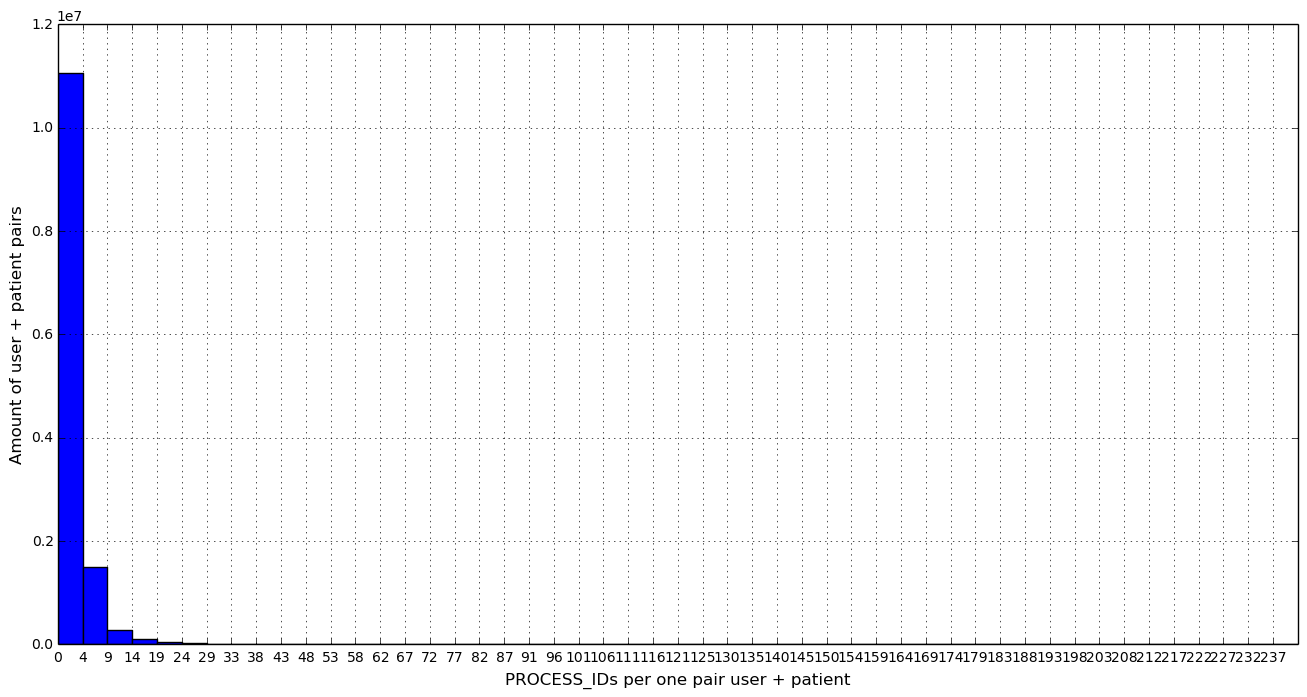

CPU times: user 503 ms, sys: 5.21 ms, total: 508 ms
Wall time: 4.82 s


In [7]:
%%time

def bins(d, num):
    avg = len(d) / float(num)
    out = []
    idx = [0]
    last = 0.0
    while last < len(d):
        s = 0
        for i in range(int(last), int(last + avg)):
            try:
                s += d[i]
            except:
                continue
        out.append(s)
        idx.append(int(last + avg))
        last += avg
    return out, idx

plt.figure(figsize=(16, 8))

x = {i[0]:i[1] for i in 
             map(lambda x: (x[0], x[1]), up.filter("EPIC_PATIENT_ID != ''").groupBy("PROCESS_IDs").count().collect()) }
N = 50
X, idx = bins(x, N)
ind = np.arange(len(X))
plt.bar(ind, X, width=1)
plt.xticks(ind, idx)
plt.xlabel("PROCESS_IDs per one pair user + patient", fontsize=12)
plt.ylabel('Amount of user + patient pairs', fontsize=12)
plt.grid(True)
plt.show()

**Show more detailed the range betwwen 1 and 10 PROCESS_IDs per one user + patient pair**

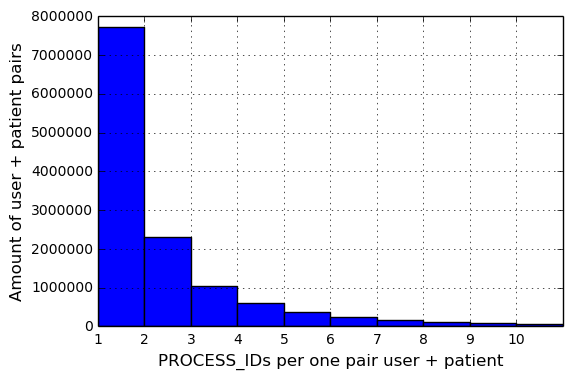

In [8]:
X = dict((key, value) for key, value in x.iteritems() if key <= 10)
ind = np.arange(len(X))
plt.bar(ind, X.values(), width=1)
plt.xticks(ind, X.keys())
plt.xlabel("PROCESS_IDs per one pair user + patient", fontsize=12)
plt.ylabel('Amount of user + patient pairs', fontsize=12)
plt.grid(True)
plt.show()

In [11]:
total = sum(x.values())
bin1 = x[1]
print 'Percent of user + patient pairs "communicating" through only one PROCESS_ID:', bin1 * 100.0 / total

Percent of user + patient pairs "communicating" through only one PROCESS_ID: 59.2842550063


---
> * There are about 60% of user + patient pair determined within only one PROCESS_ID

---

# Investigate how many workstations are related with a PROCESS_ID

In [40]:
%%time
query = " ".join([
    "SELECT PROCESS_ID, COUNT(DISTINCT(WORKSTATION)) AS WORKSTATIONS",
    "FROM data WHERE WORKSTATION != '' OR WORKSTATION IS NOT NULL",
    "GROUP BY PROCESS_ID ORDER BY WORKSTATIONS DESC"
])

w = sqlContext.sql(query).persist()
w.show(10)

+------------+------------+
|  PROCESS_ID|WORKSTATIONS|
+------------+------------+
| prd-6883290|         576|
|prd-11994382|         574|
|prd-11863714|         574|
|prd-36373008|         556|
|prd-29884918|         546|
|prd-44565056|         541|
|prd-49284162|         525|
|prd-15401534|         514|
|prd-31720288|         510|
|prd-34800986|         502|
+------------+------------+
only showing top 10 rows

CPU times: user 26.3 ms, sys: 5.22 ms, total: 31.5 ms
Wall time: 15.4 s


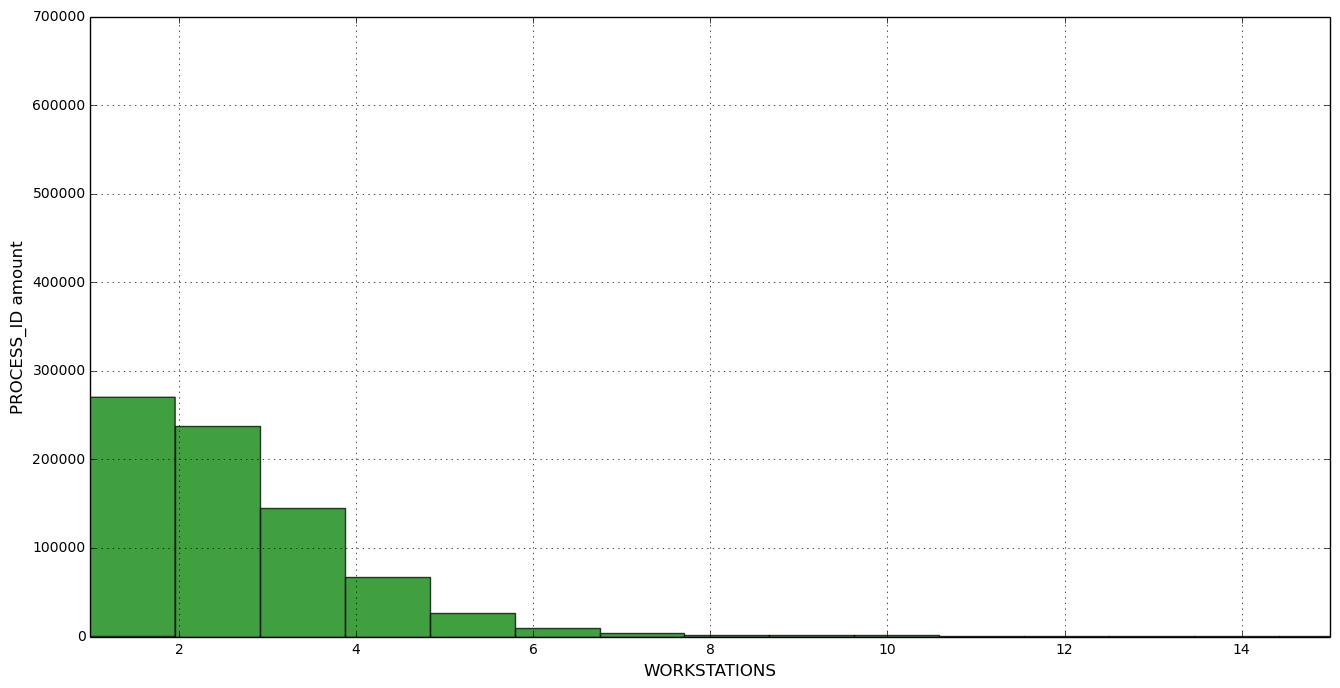

CPU times: user 4.39 s, sys: 159 ms, total: 4.55 s
Wall time: 5.01 s


In [41]:
%%time

plt.figure(figsize=(16, 8))
x = np.array(map(lambda x: x[0], w.select("WORKSTATIONS").collect()))
plt.hist(x, 600, facecolor='green', alpha=0.75)
plt.xlabel("WORKSTATIONS", fontsize=12)
plt.ylabel('PROCESS_ID amount', fontsize=12)
plt.axis([1, 15, 0, 700000])
plt.grid(True)
plt.show()

In [42]:
w1 = w.filter("WORKSTATIONS == 1").count()
w2 = w.filter("WORKSTATIONS == 2").count()
w3 = w.filter("WORKSTATIONS == 3").count()
w4 = w.filter("WORKSTATIONS == 4").count()
w5 = w.filter("WORKSTATIONS == 5").count()
w_all = w.count()
for i, j in enumerate((w1, w2, w3, w4, w5)):
    print "Percent of PROCESS_IDs with {0} workstation(s): {1:.3f}%".format(i+1, j*100.0/w_all)
print "Percent of PROCESS_IDs with more than 5 workstations: {0:.3f}%".format(100 - (w1+w2+w3+w4+w5)*100.0/w_all)

Percent of PROCESS_IDs with 1 workstation(s): 34.701%
Percent of PROCESS_IDs with 2 workstation(s): 30.503%
Percent of PROCESS_IDs with 3 workstation(s): 18.572%
Percent of PROCESS_IDs with 4 workstation(s): 8.614%
Percent of PROCESS_IDs with 5 workstation(s): 3.355%
Percent of PROCESS_IDs with more than 5 workstations: 4.255%


---
> * PROCESS_ID doesn't mean that it is used only one workstation
> * Mostly one PROCESS_ID has from 1 to 4 workstations, but there are PROCESS_IDs with about 600 workstations

---

# Let's look in details on the behaviour inside some PROCESS_IDs

**1) `PROCESS_ID = 'prd-17367470'`**

In [5]:
prd_17367470 = data.filter("PROCESS_ID = 'prd-17367470'").persist()
sqlContext.registerDataFrameAsTable(prd_17367470, "prd_17367470")

print "Records for 'prd-17367470':", prd_17367470.rdd.count()

users = sqlContext.sql("SELECT DISTINCT(USER_ID) FROM prd_17367470").collect()
users = map(lambda x: str(x[0]), users)
print "Users [{}]:\n".format(len(users)), users

patients = sqlContext.sql("SELECT DISTINCT(EPIC_PATIENT_ID) FROM prd_17367470").collect()
patients = map(lambda x: str(x[0]), patients)
print "Patients [{}]:\n".format(len(patients)), patients

Records for 'prd-17367470': 2860
Users [4]:
['203965', '115822', '10627', '14463']
Patients [108]:
['6139193', '5812924', '4175880', '4261016', '5695020', 'Z3965790', '4156894', '5261521', '4638547', '4299302', '5815238', 'Z4097193', 'Z2626793', '5133994', '4424966', 'Z4092668', '4339750', '5207578', '4273639', '4197052', 'Z2613032', '5474270', '4636341', '4687892', '5270318', '5506866', '5776284', '4337618', '4253260', '4316587', '4702453', '3686548', '4390022', '4583733', '5264138', '4353856', 'Z2868598', 'Z4014961', '5068022', 'Z4051254', '4255437', '6051318', '4275787', '4530074', '4415087', '5454256', '4510289', '4422270', '5023236', '4694773', 'Z4133619', '4325741', '4725473', '4362118', '5277502', '4223761', '5240402', '5049657', '5077995', '5747383', '3922458', '4701332', '4725732', '5207649', '4292712', '4313134', '4360017', '4059916', '4358888', '4424395', '6137581', 'Z4058788', '4210795', '4175699', 'Z4074241', '5244727', '6262494', '3787605', '4139955', '4298351', 'Z2638161

In [12]:
user_patient = sqlContext.sql(
    "SELECT USER_ID, COUNT(DISTINCT(EPIC_PATIENT_ID)) AS AMOUNT, concat_ws('; ', collect_set(EPIC_PATIENT_ID)) AS PATIENTS " +\
    "FROM prd_17367470 GROUP BY USER_ID"
).toPandas()
user_patient.head()

,USER_ID,AMOUNT,PATIENTS
0,203965,1,4636341
1,115822,1,4422270
2,10627,4,5812924; 4702453; 4583733; Z2638161
3,14463,102,4292712; 4325741; 4370148; 3922458; 4059916; 5068022; 3783629; Z2597446; Z4095931; 4390022; 4687892; 5454256; 4261016; 5240402; 4510233; 4175699; 4450831; 4734964; 5724351; 4139955; 4275787; Z4014961; ; 3851771; 4223761; 6137581; 4337618; Z409719...


**2) `PROCESS_ID = 'prd-58196114'`**

In [13]:
prd_58196114 = data.filter("PROCESS_ID = 'prd-58196114'").persist()
sqlContext.registerDataFrameAsTable(prd_58196114, "prd_58196114")

print "Records for 'prd-prd_58196114':", prd_58196114.rdd.count()

users = sqlContext.sql("SELECT DISTINCT(USER_ID) FROM prd_58196114").collect()
users = map(lambda x: str(x[0]), users)
print "Users [{}]:\n".format(len(users)), users

patients = sqlContext.sql("SELECT DISTINCT(EPIC_PATIENT_ID) FROM prd_58196114").collect()
patients = map(lambda x: str(x[0]), patients)
print "Patients [{}]:\n".format(len(patients)), patients

Records for 'prd-prd_58196114': 1444
Users [7]:
['201586', '17371', '206468', '200866', '706029', '115882', '10627']
Patients [78]:
['Z3794716', '3922777', 'Z4042711', 'Z2595841', '6218995', '3945007', 'Z4036686', '4384346', '3831465', '4554270', 'Z3790600', '5517826', 'Z2720391', '4361651', '3992457', '5783918', '2151640', '5660283', '4736161', 'Z3853828', '5036808', '4359242', '4470307', 'Z4059709', '4248940', '4181865', 'Z4048866', 'Z2820504', '4306609', '4344847', 'Z4068419', '5653217', '5521515', 'Z3771576', '4149968', '6130489', '3569124', '3570027', '4949396', '5268498', 'Z3314013', '2057769', '4218225', '4781630', 'Z4068914', '5673198', '4526175', '6133601', 'Z2792460', '4247315', 'Z3992282', 'Z2845945', '4262237', '4611757', '3304745', 'Z3938997', '3929160', '4833717', '4523657', 'Z4152384', '5638782', '3570946', 'Z4060450', 'Z2638161', '4323323', '4314455', '5191570', '6048698', '', '4517413', 'Z2620131', 'Z4042097', '4406651', '5733950', '4392703', '4379138', '4399047', '448

In [17]:
user_patient = sqlContext.sql(
    "SELECT USER_ID, COUNT(DISTINCT(EPIC_PATIENT_ID)) AS AMOUNT, concat_ws('; ', collect_set(EPIC_PATIENT_ID)) AS PATIENTS " +\
    "FROM prd_58196114 GROUP BY USER_ID"
).toPandas()
user_patient.head(10)

,USER_ID,AMOUNT,PATIENTS
0,201586,1,5268498
1,17371,65,Z3938997; 5673198; 3569124; Z2620131; Z4042097; 5660283; 6048698; 4361651; 5733950; 4149968; 6133601; Z4060450; Z4036686; ; Z4152384; 4181865; Z3853828; 2151640; 3570027; 5517826; Z3771576; 4247315; 3831465; 4406651; 4484510; Z4068419; 6130489; 4...
2,206468,2,5268498;
3,200866,1,5268498
4,706029,3,; 6218995; 5783918
5,115882,1,5268498
6,10627,11,5653217; Z3790600; 4306609; 4736161; 4781630; Z3314013; Z4059709; Z2638161; ; 5036808; 4833717


---
> * Inside a PROCESS_ID all pairs user + patient **are NOT unique**, i.e. there are patients that are related with two or more users within one PROCESS_ID

---

### Let's look which actions have been done within the PROCESS_ID `"prd-17367470"`

In [15]:
user_patient_modules = sqlContext.sql(
    "SELECT USER_ID, EPIC_PATIENT_ID, COUNT(DISTINCT(MODULE)) AS AMOUNT, concat_ws('; ', collect_set(MODULE)) AS MODULES " +\
    "FROM prd_17367470 GROUP BY USER_ID, EPIC_PATIENT_ID ORDER BY USER_ID"
).toPandas()
user_patient_modules.head(10)

,USER_ID,EPIC_PATIENT_ID,AMOUNT,MODULES
0,10627,5812924,3,Patient Chart Review; PATIENT CLINICAL INFO; In Basket Report
1,10627,Z2638161,2,PATIENT CLINICAL INFO; In Basket Report
2,10627,4583733,2,PATIENT CLINICAL INFO; In Basket Report
3,10627,4702453,2,PATIENT CLINICAL INFO; In Basket Report
4,115822,4422270,1,PATIENT CLINICAL INFO
5,14463,4091084,6,PATIENT DEMOGRAPHICS; MASTER FILE/ADMIN; Patient Chart Review; PATIENT CLINICAL INFO; ; Printing
6,14463,4273639,6,PATIENT DEMOGRAPHICS; MASTER FILE/ADMIN; Patient Chart Review; PATIENT CLINICAL INFO; ; Printing
7,14463,5264138,1,Printing
8,14463,5244727,2,PATIENT DEMOGRAPHICS; MASTER FILE/ADMIN
9,14463,5261521,1,Printing


### Let's look which actions have been done within the PROCESS_ID `"prd-58196114"`

In [18]:
user_patient_modules = sqlContext.sql(
    "SELECT USER_ID, EPIC_PATIENT_ID, COUNT(DISTINCT(MODULE)) AS AMOUNT, concat_ws('; ', collect_set(MODULE)) AS MODULES " +\
    "FROM prd_58196114 GROUP BY USER_ID, EPIC_PATIENT_ID ORDER BY USER_ID"
).toPandas()
user_patient_modules.head(15)

,USER_ID,EPIC_PATIENT_ID,AMOUNT,MODULES
0,10627,5036808,3,Patient Chart Review; PATIENT ORDERS; PATIENT CLINICAL INFO
1,10627,Z3790600,3,PCP History; PATIENT CLINICAL INFO; In Basket Report
2,10627,Z4059709,2,PATIENT CLINICAL INFO; In Basket Report
3,10627,4833717,3,PATIENT ORDERS; PATIENT CLINICAL INFO; In Basket Report
4,10627,4306609,3,Patient Chart Review; PATIENT ORDERS; PATIENT CLINICAL INFO
5,10627,4781630,2,PATIENT CLINICAL INFO; In Basket Report
6,10627,Z3314013,5,Patient Chart Review; LOG ENTRY; PATIENT ORDERS; PATIENT CLINICAL INFO; In Basket Report
7,10627,,1,Printing
8,10627,Z2638161,5,PCP History; Patient Chart Review; PATIENT ORDERS; PATIENT CLINICAL INFO; In Basket Report
9,10627,4736161,2,Patient Chart Review; PATIENT CLINICAL INFO


## Which actions have been done for some user + patient pair (we've chosen `USER_ID = '10627'` AND `EPIC_PATIENT_ID = 'Z2638161'`) within other PROCESS_IDs and which workstations were used

In [19]:
sqlContext.sql(
    "SELECT PROCESS_ID, COUNT(DISTINCT(MODULE)) AS AMOUNT, concat_ws('; ', collect_set(MODULE)) AS MODULES " +\
    "FROM data " + \
    "WHERE USER_ID = '10627' AND EPIC_PATIENT_ID = 'Z2638161' " +\
    "GROUP BY PROCESS_ID"
).toPandas().head(15)

,PROCESS_ID,AMOUNT,MODULES
0,prd-17367470,2,PATIENT CLINICAL INFO; In Basket Report
1,prd-27395068,1,PATIENT CLINICAL INFO
2,prd-20382026,1,Printing
3,prd-58196114,5,PCP History; Patient Chart Review; PATIENT ORDERS; PATIENT CLINICAL INFO; In Basket Report
4,prd-33882582,2,PATIENT CLINICAL INFO; In Basket Report
5,prd-8192214,1,PATIENT ORDERS
6,prd-6161996,1,PATIENT ORDERS
7,prd-41353408,1,Printing
8,prd-15270054,2,PATIENT CLINICAL INFO; In Basket Report
9,prd-45088872,3,Patient Chart Review; PATIENT ORDERS; PATIENT CLINICAL INFO


In [20]:
sqlContext.sql(
    "SELECT PROCESS_ID, COUNT(DISTINCT(WORKSTATION)) AS AMOUNT, concat_ws('; ', collect_set(WORKSTATION)) AS WORKSTATIONS " +\
    "FROM data " + \
    "WHERE USER_ID = '10627' AND EPIC_PATIENT_ID = 'Z2638161' " +\
    "GROUP BY PROCESS_ID"
).toPandas().head(15)

,PROCESS_ID,AMOUNT,WORKSTATIONS
0,prd-17367470,1,GENERIC
1,prd-27395068,1,HY4742
2,prd-20382026,1,
3,prd-58196114,1,ENDODT016
4,prd-33882582,1,WA4TC014
5,prd-8192214,1,
6,prd-6161996,1,
7,prd-41353408,1,
8,prd-15270054,1,GENERIC
9,prd-45088872,1,HY3009


## Which actions have been done for some user + patient pair (we've chosen `USER_ID = '10627'` AND `EPIC_PATIENT_ID = 'Z3314013'`) within other PROCESS_IDs and which workstations were used

In [22]:
sqlContext.sql(
    "SELECT PROCESS_ID, COUNT(DISTINCT(MODULE)) AS AMOUNT, concat_ws('; ', collect_set(MODULE)) AS MODULES " +\
    "FROM data " + \
    "WHERE USER_ID = '10627' AND EPIC_PATIENT_ID = 'Z3314013' " +\
    "GROUP BY PROCESS_ID"
).toPandas().head(25)

,PROCESS_ID,AMOUNT,MODULES
0,prd-39976990,3,Patient Chart Review; PATIENT ORDERS; PATIENT CLINICAL INFO
1,prd-32180120,3,Patient Chart Review; PATIENT CLINICAL INFO; Printing
2,prd-22743018,3,PCP History; PATIENT CLINICAL INFO; In Basket Report
3,prd-58196114,5,Patient Chart Review; LOG ENTRY; PATIENT ORDERS; PATIENT CLINICAL INFO; In Basket Report
4,prd-25560472,2,PATIENT CLINICAL INFO; In Basket Report
5,prd-48759986,1,PATIENT ORDERS
6,prd-6161996,1,PATIENT ORDERS
7,prd-33228366,3,Patient Chart Review; PATIENT ORDERS; PATIENT CLINICAL INFO
8,prd-1704988,2,PATIENT CLINICAL INFO; In Basket Report
9,prd-7340746,2,PATIENT CLINICAL INFO; In Basket Report


In [23]:
sqlContext.sql(
    "SELECT PROCESS_ID, COUNT(DISTINCT(WORKSTATION)) AS AMOUNT, concat_ws('; ', collect_set(WORKSTATION)) AS WORKSTATIONS " +\
    "FROM data " + \
    "WHERE USER_ID = '10627' AND EPIC_PATIENT_ID = 'Z3314013' " +\
    "GROUP BY PROCESS_ID"
).toPandas().head(25)

,PROCESS_ID,AMOUNT,WORKSTATIONS
0,prd-39976990,1,HY3009
1,prd-32180120,1,WS1048
2,prd-22743018,1,HY3009
3,prd-58196114,1,ENDODT016
4,prd-25560472,1,WA4TC007
5,prd-48759986,1,
6,prd-6161996,1,
7,prd-33228366,1,HY3009
8,prd-1704988,1,3NWAPODE1
9,prd-7340746,1,2NEANS04


---
> * We cannot say that a PROCES_ID corresponds to some group of requests which a user does with a patient's profile

---

# Lets' visualize dynamics of PROCESS_IDs usage in time

**USER_ID = '10627' AND EPIC_PATIENT_ID = 'Z2638161'**

In [45]:
vals = sqlContext.sql(
    "SELECT PROCESS_ID, ACCESS_DATE, COUNT(ACCESS_DTTM) AS amount " +\
    "FROM data " + \
    "WHERE USER_ID = '10627' AND EPIC_PATIENT_ID = 'Z2638161' " +\
    "GROUP BY PROCESS_ID, ACCESS_DATE ORDER BY ACCESS_DATE"
)
vals.toPandas().head(25)

,PROCESS_ID,ACCESS_DATE,amount
0,prd-17367470,2016-08-09,8
1,prd-6161996,2016-08-19,4
2,prd-58196114,2016-08-19,38
3,prd-41353408,2016-08-19,2
4,prd-33882582,2016-08-19,13
5,prd-15270054,2016-08-22,12
6,prd-25560402,2016-08-23,31
7,prd-20382026,2016-09-20,1
8,prd-27395068,2016-09-20,1
9,prd-15729074,2016-09-20,46


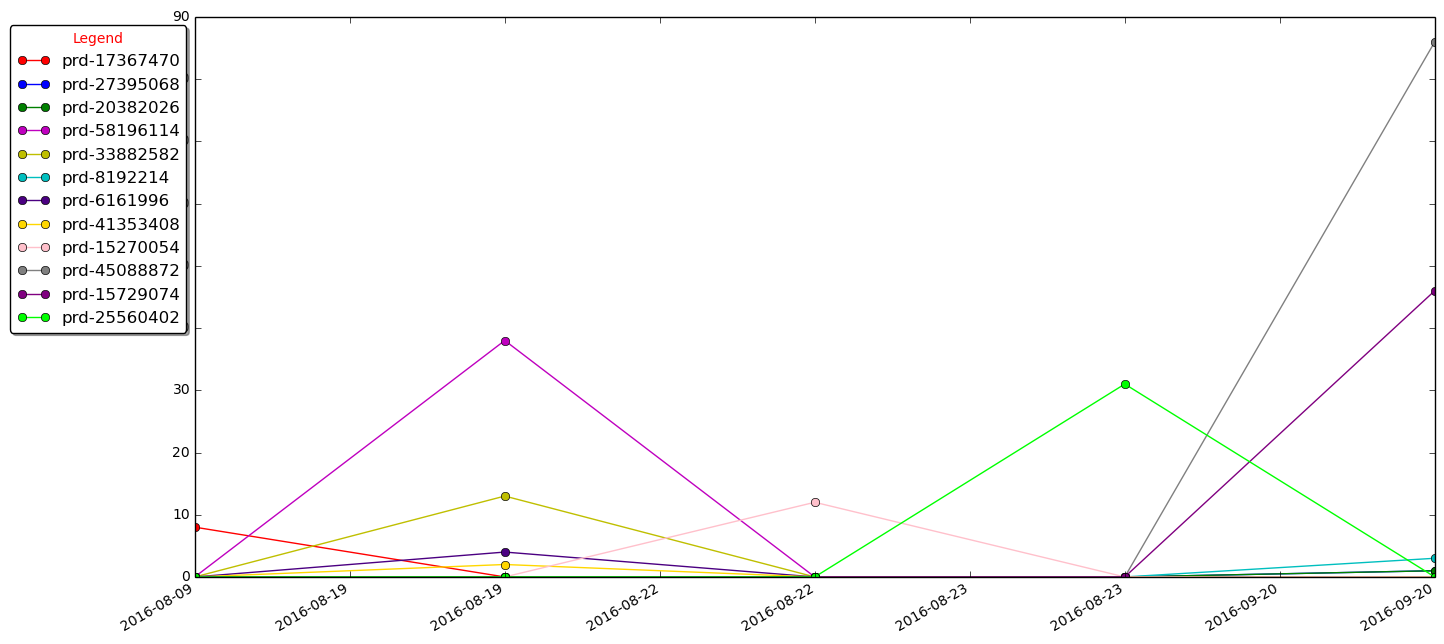

In [56]:
from matplotlib.ticker import Formatter

class MyFormatter(Formatter):
    def __init__(self, dates, fmt='%Y-%m-%d'):
        self.dates = dates
        self.fmt = fmt

    def __call__(self, x, pos=0):
        'Return the label for time x at position pos'
        ind = int(round(x))
        if ind >= len(self.dates) or ind < 0:
            return ''
        return self.dates[ind].strftime(self.fmt)
    
dates = vals.select("ACCESS_DATE").distinct().collect()
dates = np.array(map(lambda x: x[0], dates))
processes = vals.select("PROCESS_ID").distinct().collect()
processes = np.array(map(lambda x: x[0], processes))

formatter = MyFormatter(dates)
colors = (
    'r', 'b', 'g', 'm', 'y', 'c', 'indigo', 'gold', 'pink', 'grey', 
    'purple', 'lime', 'darkred', 'salmon', 'navy', 'brown', 'coral'
)

fig, ax = plt.subplots(figsize=(16,8))
ax.xaxis.set_major_formatter(formatter)
for p, c in zip(processes, colors):
    y = vals.filter("PROCESS_ID = '{}'".format(p)).select("ACCESS_DATE", "amount").collect()
    y = {i[0]: i[1] for i in map(lambda x: (x[0], x[1]), y)}
    y = [y[i] if i in y.keys() else 0 for i in dates]
    ax.plot(np.arange(len(dates)), y, 'o-', c=c, label=p)
plt.legend(loc="upper right", bbox_to_anchor=[0, 1], shadow=True, title="Legend", fancybox=True)
ax.get_legend().get_title().set_color("red")
fig.autofmt_xdate()
plt.show()

In [57]:
vals2 = sqlContext.sql(
    "SELECT MODULE, ACCESS_DATE, COUNT(DISTINCT(PROCESS_ID)) AS amount " +\
    "FROM data " + \
    "WHERE USER_ID = '10627' AND EPIC_PATIENT_ID = 'Z2638161' " +\
    "GROUP BY MODULE, ACCESS_DATE ORDER BY ACCESS_DATE"
)
vals2.toPandas().head(25)

,MODULE,ACCESS_DATE,amount
0,In Basket Report,2016-08-09,1
1,PATIENT CLINICAL INFO,2016-08-09,1
2,PCP History,2016-08-19,1
3,PATIENT CLINICAL INFO,2016-08-19,2
4,PATIENT ORDERS,2016-08-19,2
5,Printing,2016-08-19,1
6,Patient Chart Review,2016-08-19,1
7,In Basket Report,2016-08-19,2
8,PATIENT CLINICAL INFO,2016-08-22,1
9,In Basket Report,2016-08-22,1


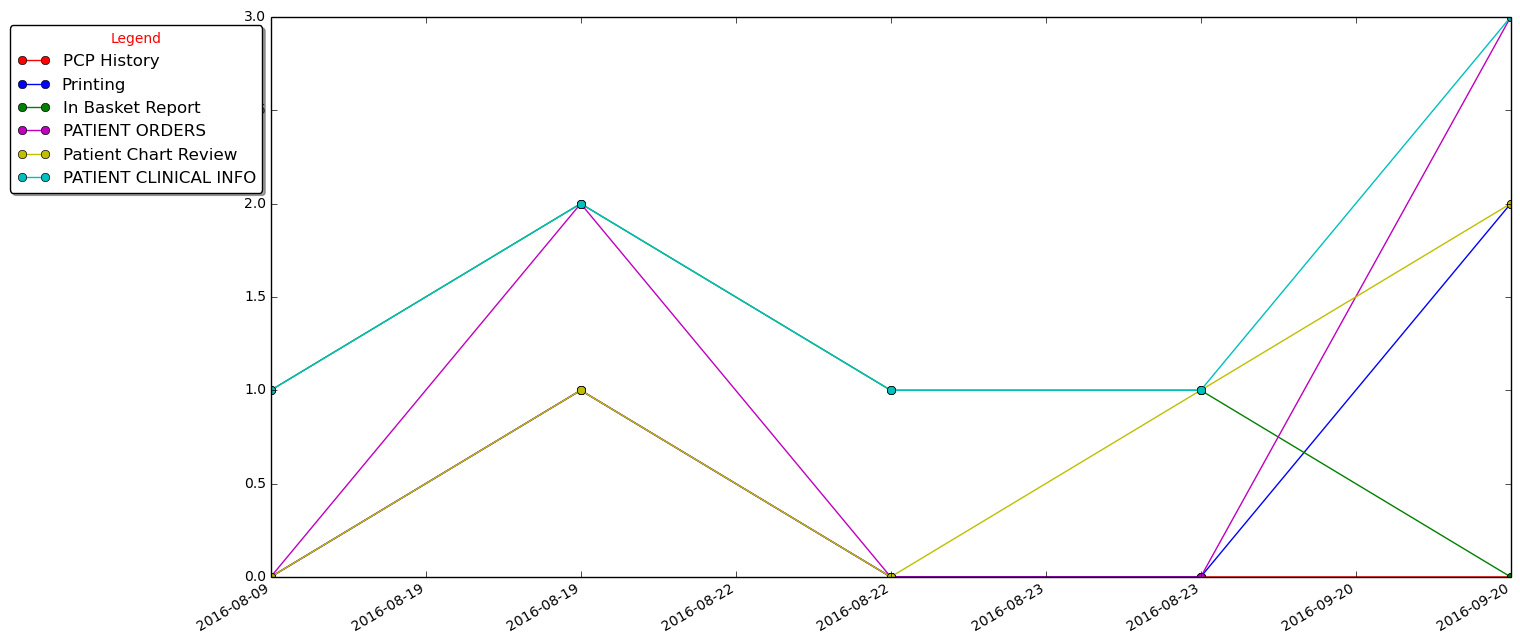

In [59]:
dates = vals2.select("ACCESS_DATE").distinct().collect()
dates = np.array(map(lambda x: x[0], dates))
modules = vals2.select("MODULE").distinct().collect()
modules = np.array(map(lambda x: x[0], modules))

formatter = MyFormatter(dates)

fig, ax = plt.subplots(figsize=(16,8))
ax.xaxis.set_major_formatter(formatter)
for m, c in zip(modules, colors):
    y = vals2.filter("MODULE = '{}'".format(m)).select("ACCESS_DATE", "amount").collect()
    y = {i[0]: i[1] for i in map(lambda x: (x[0], x[1]), y)}
    y = [y[i] if i in y.keys() else 0 for i in dates]
    ax.plot(np.arange(len(dates)), y, 'o-', c=c, label=m)
plt.legend(loc="upper right", bbox_to_anchor=[0, 1], shadow=True, title="Legend", fancybox=True)
ax.get_legend().get_title().set_color("red")
fig.autofmt_xdate()
plt.show()

**USER_ID = '10627' AND EPIC_PATIENT_ID = 'Z3314013'**

In [60]:
vals = sqlContext.sql(
    "SELECT PROCESS_ID, ACCESS_DATE, COUNT(ACCESS_DTTM) AS amount " +\
    "FROM data " + \
    "WHERE USER_ID = '10627' AND EPIC_PATIENT_ID = 'Z3314013' " +\
    "GROUP BY PROCESS_ID, ACCESS_DATE ORDER BY ACCESS_DATE"
)
vals.toPandas().head(5)

,PROCESS_ID,ACCESS_DATE,amount
0,prd-26019594,2016-07-06,44
1,prd-10422246,2016-07-06,1
2,prd-48759986,2016-07-06,1
3,prd-33228366,2016-07-06,81
4,prd-1704988,2016-07-07,4


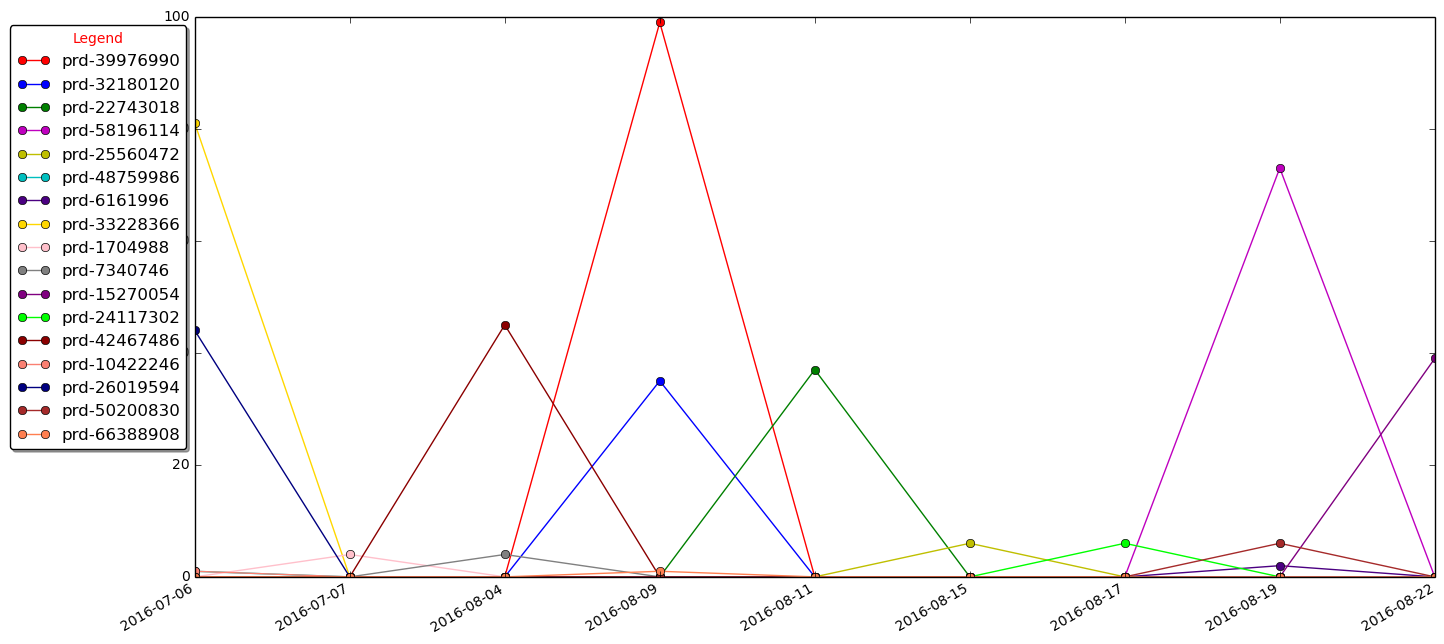

In [62]:
dates = vals.select("ACCESS_DATE").distinct().collect()
dates = np.array(map(lambda x: x[0], dates))
processes = vals.select("PROCESS_ID").distinct().collect()
processes = np.array(map(lambda x: x[0], processes))

formatter = MyFormatter(dates)

fig, ax = plt.subplots(figsize=(16,8))
ax.xaxis.set_major_formatter(formatter)
for p, c in zip(processes, colors):
    y = vals.filter("PROCESS_ID = '{}'".format(p)).select("ACCESS_DATE", "amount").collect()
    y = {i[0]: i[1] for i in map(lambda x: (x[0], x[1]), y)}
    y = [y[i] if i in y.keys() else 0 for i in dates]
    ax.plot(np.arange(len(dates)), y, 'o-', c=c, label=p)
plt.legend(loc="upper right", bbox_to_anchor=[0, 1], shadow=True, title="Legend", fancybox=True)
ax.get_legend().get_title().set_color("red")
fig.autofmt_xdate()
plt.show()

In [64]:
vals2 = sqlContext.sql(
    "SELECT MODULE, ACCESS_DATE, COUNT(DISTINCT(PROCESS_ID)) AS amount " +\
    "FROM data " + \
    "WHERE USER_ID = '10627' AND EPIC_PATIENT_ID = 'Z3314013' " +\
    "GROUP BY MODULE, ACCESS_DATE ORDER BY ACCESS_DATE"
)
vals2.toPandas().head(5)

,MODULE,ACCESS_DATE,amount
0,PATIENT CLINICAL INFO,2016-07-06,3
1,Patient Chart Review,2016-07-06,2
2,Printing,2016-07-06,1
3,PATIENT ORDERS,2016-07-06,3
4,In Basket Report,2016-07-07,1


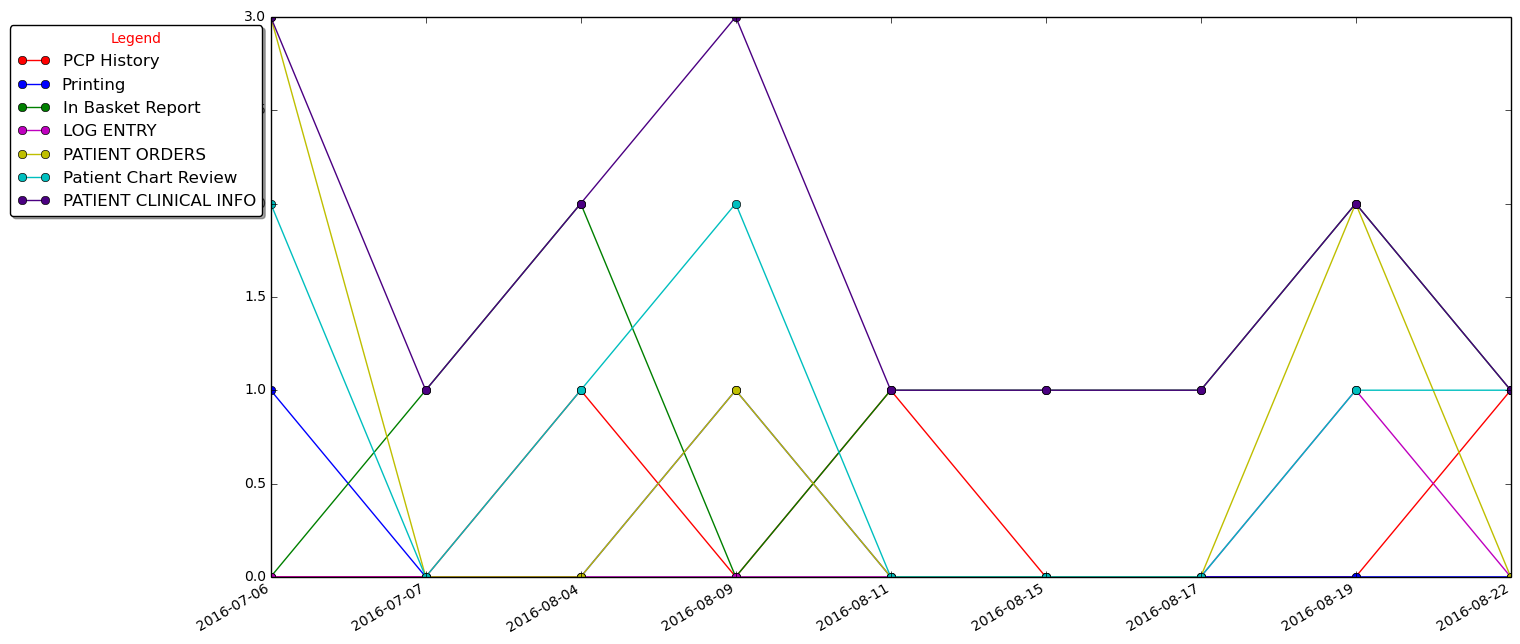

In [65]:
dates = vals2.select("ACCESS_DATE").distinct().collect()
dates = np.array(map(lambda x: x[0], dates))
modules = vals2.select("MODULE").distinct().collect()
modules = np.array(map(lambda x: x[0], modules))

formatter = MyFormatter(dates)

fig, ax = plt.subplots(figsize=(16,8))
ax.xaxis.set_major_formatter(formatter)
for m, c in zip(modules, colors):
    y = vals2.filter("MODULE = '{}'".format(m)).select("ACCESS_DATE", "amount").collect()
    y = {i[0]: i[1] for i in map(lambda x: (x[0], x[1]), y)}
    y = [y[i] if i in y.keys() else 0 for i in dates]
    ax.plot(np.arange(len(dates)), y, 'o-', c=c, label=m)
plt.legend(loc="upper right", bbox_to_anchor=[0, 1], shadow=True, title="Legend", fancybox=True)
ax.get_legend().get_title().set_color("red")
fig.autofmt_xdate()
plt.show()

---

> * PROCESS_IDs' amount for one and the same MODULE query may changing from day to day
> * Usage of PROCESS_IDs in time is not stable

---